# Stock Proce Predictor
### Udacity Data Scientist Nanodegree - Capstone Project

This notebook covers
* the integration of Yahoo stock price data,
* the exploration of stock price data,
* data preprocessing, and
* the comparison of different predictor models.

The code will then be utilized to build a flask app for predicting stock prices.

The predictor's performance is measured against the actual future price with a variance of 5% (Udacity requirement) plus further indicators.

**Disclaimer:** Do not use this project for investment decisions. This project is for education purposes only.

## Table of Contents

01   [Obtaining & Exploring the Data](#Exploration)<br>
02   [Data Preprocessing](#Preprocessing)<br>
03   [Model: Recurrent Neural Network](#RNN)<br>
04   [Model: Multiple Linear Regression](#MLR)<br>
05   [Model: Random Forest Regression](#RFR)<br>


In [149]:
# Import libraries
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

import statsmodels.regression.linear_model as sm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### <a class="anchor" id="Exploration">Part 1: Obtaining & Exploring the Data</a>

In [2]:
# Import Yahoo Finance CSV Data on Microsoft stock
data = pd.read_csv('data/MSFT.csv')

In [3]:
data.head(-10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500
1,2015-05-01,48.580002,48.880001,48.400002,48.660000,43.875984,38937300
2,2015-05-04,48.369999,48.869999,48.180000,48.240002,43.497272,34039500
3,2015-05-05,47.820000,48.160000,47.310001,47.599998,42.920189,50369200
4,2015-05-06,47.570000,47.770000,46.020000,46.279999,41.729969,52433000
...,...,...,...,...,...,...,...
1244,2020-04-08,165.669998,166.669998,163.500000,165.130005,165.130005,48318200
1245,2020-04-09,166.360001,167.369995,163.330002,165.139999,165.139999,51431800
1246,2020-04-13,164.350006,165.570007,162.300003,165.509995,165.509995,41905300
1247,2020-04-14,169.000000,173.750000,168.000000,173.699997,173.699997,52874300


In [4]:
data['Adj Close']

0        43.857941
1        43.875984
2        43.497272
3        42.920189
4        41.729969
           ...    
1254    171.419998
1255    174.550003
1256    174.050003
1257    169.809998
1258    177.429993
Name: Adj Close, Length: 1259, dtype: float64

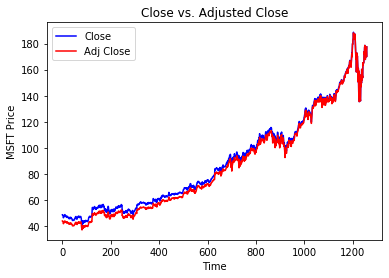

In [5]:
# Plot Close and Adjusted Close for comparison
plt.plot(data['Close'], color = 'blue', label = 'Close')
plt.plot(data['Adj Close'], color = 'red', label = 'Adj Close')
plt.title('Close vs. Adjusted Close')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

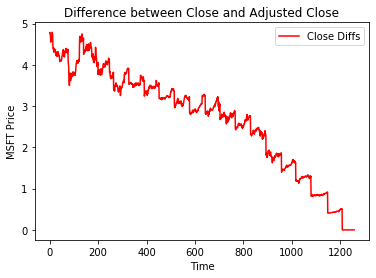

In [6]:
# Plot difference between Close and Adjusted Close
close_diffs = data.copy()
close_diffs['Close Diffs'] = close_diffs['Close'] - close_diffs['Adj Close']

plt.plot(close_diffs['Close Diffs'], color = 'red', label = 'Close Diffs')
plt.title('Difference between Close and Adjusted Close')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

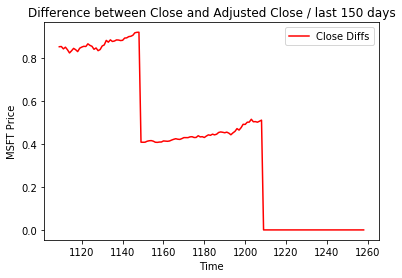

In [7]:
# Take a closer look at Close Diffs
plt.plot(close_diffs['Close Diffs'][-150:], color = 'red', label = 'Close Diffs')
plt.title('Difference between Close and Adjusted Close / last 150 days')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

**Comment**

Yahoo Finance applies the following adjustments to the numbers:
1. Close price adjusted for splits.
2. Adjusted close price adjusted for both dividends and splits.

The effect of dividends can clearly be seen in the above chart: Every three months Microsoft's (MSFT) shareholders earn a dividend. The close price is then adjusted by this cash outflow so that the adjusted close price better resembles the value of the company (and its stocks respectively) after the dividend event. Since cash (in form of dividend payments) leaves the company but is not reinvested, the value of the company and its shares respectively dilute.

Udacity's requirement for this capstone project is to predict the **adjusted close price**. Hence, this is the value the prediction models will concentrate on.

### <a class="anchor" id="Preprocessing">Part 2: Data Preprocessing</a>

In [3]:
def import_data(data = 'data/MSFT.csv'):
    '''
    Function to import and preprocess stock price data from Yahoo Finance for further usage.
    Input: Path to CSV file provided by Yahoo Finance
    Output: Preprocessed DataFrame
    '''
    df = pd.read_csv(data)
    df = preprocessing_data(df)
    return df


def preprocessing_data(df):
    '''
    Function to preprocess data: cleaning, forward-fill and backward-fill for nan values
    Input: df with stock price data
    Output: Preprocessed DataFrame
    '''
    # Check if there are nan values
    for col in df.columns:
        if df[col].isnull().sum() >> 0:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        else:
            continue
         
    return df

In [9]:
# Test functions
# Add nan value in one column
df_1nan = import_data()
df_1nan['Close'][4] = np.nan
df_1nan.head()

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500
1,2015-05-01,48.580002,48.880001,48.400002,48.660000,43.875984,38937300
2,2015-05-04,48.369999,48.869999,48.180000,48.240002,43.497272,34039500
3,2015-05-05,47.820000,48.160000,47.310001,47.599998,42.920189,50369200
4,2015-05-06,47.570000,47.770000,46.020000,NaN,41.729969,52433000


In [10]:
# Test preprocessing function for one nan
df_1nan = preprocessing_data(df_1nan)
assert df_1nan['Close'][4] == df_1nan['Close'][3], 'forward-fill did not work'

In [11]:
# Test preprocessing function for more nan values
df_nans = import_data()
df_nans['Close'][3] = np.nan

# Create DataFrame with one row of nan values
nan_list = [np.nan for _ in range(len(df_nans.columns))]
nanrow_df = pd.DataFrame(nan_list)#, columns = df_nans.columns.to_list())
nanrow_df = nanrow_df.T
nanrow_df.columns = df_nans.columns.to_list()

# Create a DataFrame with nan values at the beginning (test backward-fill), in the middle and the end (test forward-fill)
nans_df = nanrow_df.append(df_nans)
nans_df = nans_df.append(nanrow_df)
nans_df

/home/max/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500.0
1,2015-05-01,48.580002,48.880001,48.400002,48.660000,43.875984,38937300.0
2,2015-05-04,48.369999,48.869999,48.180000,48.240002,43.497272,34039500.0
3,2015-05-05,47.820000,48.160000,47.310001,NaN,42.920189,50369200.0
...,...,...,...,...,...,...,...
1255,2020-04-24,172.059998,174.559998,170.710007,174.550003,174.550003,34305300.0
1256,2020-04-27,176.589996,176.899994,173.300003,174.050003,174.050003,33194400.0
1257,2020-04-28,175.589996,175.669998,169.389999,169.809998,169.809998,34392700.0
1258,2020-04-29,173.220001,177.679993,171.880005,177.429993,177.429993,50872900.0


In [12]:
# Apply preprocessing function to DataFrame with NaN values
test_nan_df = preprocessing_data(nans_df)
test_nan_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500.0
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500.0
1,2015-05-01,48.580002,48.880001,48.400002,48.660000,43.875984,38937300.0
2,2015-05-04,48.369999,48.869999,48.180000,48.240002,43.497272,34039500.0
3,2015-05-05,47.820000,48.160000,47.310001,48.240002,42.920189,50369200.0
...,...,...,...,...,...,...,...
1255,2020-04-24,172.059998,174.559998,170.710007,174.550003,174.550003,34305300.0
1256,2020-04-27,176.589996,176.899994,173.300003,174.050003,174.050003,33194400.0
1257,2020-04-28,175.589996,175.669998,169.389999,169.809998,169.809998,34392700.0
1258,2020-04-29,173.220001,177.679993,171.880005,177.429993,177.429993,50872900.0


--> both data import and preprocessing functions work properly.

### <a class="anchor" id="RNN">Part 3: Model: Recurrent Neural Network</a>

In [13]:
# Import dataset
dataset = import_data(data = 'data/MSFT.csv')

In [14]:
# Split dataset into training and test sets
df_adjClose = dataset.iloc[:, 5:6].values    # Adj. Close column
adjClose_train, adjClose_test = train_test_split(df_adjClose, test_size = 0.2, shuffle = False)    # no shuffle for time-series

In [15]:
# Feature Scaling / Data Normalization
scaler = MinMaxScaler(feature_range = (0, 1))
adjClose_train_scaled = scaler.fit_transform(adjClose_train)

In [16]:
# Create data structure with 32 timesteps and 1 output
X_train = []
y_train = []
for i in range(32, len(adjClose_train)):
    X_train.append(adjClose_train_scaled[i-32:i, 0])
    y_train.append(adjClose_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping --> Define expected dimensionality for RNN
# X_train.shape[0] = Number of rows
# X_train.shape[1] = Number of columns
# 1 = Number of features (in this case only 'Adj Close')
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
# Initialize Recurrent Neural Network (RNN)
regressor = Sequential()

# Create first long short-term memory (LSTM) layer
# units = neurons in LSTM layer
# return_sequences = True <-- as more LSTM layers will follow
# dropout <-- to counteract overfitting
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.19))

# Add second LSTM layer and dropout regularization
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.19))

# Add third LSTM layer and dropout regularization
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.19))

# Add fourth LSTM layer and dropout regularization
regressor.add(LSTM(units = 64))
regressor.add(Dropout(0.19))

# Add output layer
regressor.add(Dense(units = 1))

# Compile RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit RNN to training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
975/975 [==============================] - 4s 4ms/step - loss: 0.0370
Epoch 2/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0028A: 0s - loss: 
Epoch 3/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 4/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 5/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0024
Epoch 6/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0022
Epoch 7/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0025
Epoch 8/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0021
Epoch 9/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0022
Epoch 10/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0023
Epoch 11/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 12/100
975/975 [==============================] - 2s 2ms/step - loss: 0.0020

In [18]:
# Make preditction for Adj. Close

# Normalize training and test data (again).
# Normalization of the test data has to be done in a separate step so that it does not influence the normalization of the training data, which would be a look into the future.

inputs = df_adjClose[len(df_adjClose) - len(adjClose_test) - 32:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(32, (32+len(adjClose_test))):
    X_test.append(inputs[i-32:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


predicted_price = regressor.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

real_price = df_adjClose[len(df_adjClose) - len(adjClose_test):]

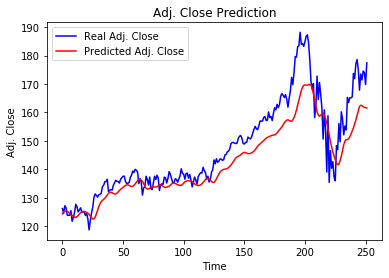

In [19]:
# Visualize the results
plt.plot(real_price, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

### <a class="anchor" id="MLR">Part 4: Model: Multiple Linear Regression</a>
A multiple linear regression model uses several features (independent variables) to predict the dependent variable y. As inputs we will use
* the full candle information (Open, High, Low, Close, Adj. Close Volume) of the previous day
* working day (Monday to Friday; these categorial features will be engineered below)

In [112]:
# Import dataset
dataset = import_data(data = 'data/MSFT.csv')

In [113]:
# Create column with weekdays from Date column
# Change column format to datetime format
dataset['Date'] = dataset['Date'].astype('datetime64[ns]')
dataset['Weekday'] = dataset['Date'].dt.day_name()

In [114]:
# Create dummy variable columns for weekdays
dataset = pd.concat([dataset, pd.get_dummies(dataset['Weekday'], drop_first = True)], axis = 1)
dataset.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume,Weekday,Monday,Thursday,Tuesday,Wednesday
0,2015-04-30,48.700001,49.540001,48.599998,48.639999,43.857941,64725500,Thursday,0,1,0,0
1,2015-05-01,48.580002,48.880001,48.400002,48.660000,43.875984,38937300,Friday,0,0,0,0
2,2015-05-04,48.369999,48.869999,48.180000,48.240002,43.497272,34039500,Monday,1,0,0,0
3,2015-05-05,47.820000,48.160000,47.310001,47.599998,42.920189,50369200,Tuesday,0,0,1,0
4,2015-05-06,47.570000,47.770000,46.020000,46.279999,41.729969,52433000,Wednesday,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1249,2020-04-16,174.300003,177.279999,172.899994,177.039993,177.039993,50479600,Thursday,0,1,0,0
1250,2020-04-17,179.500000,180.000000,175.869995,178.600006,178.600006,52765600,Friday,0,0,0,0
1251,2020-04-20,176.630005,178.750000,174.990005,175.059998,175.059998,36669600,Monday,1,0,0,0
1252,2020-04-21,173.500000,173.669998,166.110001,167.820007,167.820007,56203700,Tuesday,0,0,1,0


In [164]:
# Define X and y
X = dataset.drop(['Date', 'Weekday'], axis = 1).values
y = dataset.iloc[:, 5:6].values    # Adj. Close column

In [165]:
# Perform assignment of previous day to Adj Close
# --> Delete first row of y
y = np.delete(y, 0, 0)
# --> Delete last row of X
X = np.delete(X, -1, 0)

In [166]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [167]:
# Data Normalization
scaler_X = MinMaxScaler(feature_range = (0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range = (0, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))

In [168]:
# Fit Multiple Linear Regression Model to training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)

In [169]:
# Compare real adj. close with predicted value
# Inverse normalization of y_pred to obtain interpretable values
predicted_price = scaler_y.inverse_transform(y_pred)

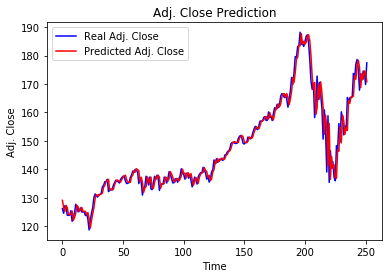

In [170]:
# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

In [210]:
# Build optimal model with backwards elimination
# Fuction to automatically remove columns where P-value is below significance level of 5%
# and adjusted R² is improved
def backward_elimination_r2(x, X_cols_mod, significance = 0.05):
    '''
    Remove the independent variables where P-values in the multiple linear regression model 
    are below a certain significance level (standard value = 5%), but ensure adjusted R² is improved
    imput:  x =  "modified X" = DataFrame with independent variables and a new column with ones for b0 (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
            X_cols_mod = list with column names of the x DataFrame
            significance = float with significance level for P-values
    output: x = modified DataFrame only containing independent variables/columns with P-values > significance
    '''
    num_vars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, axis = 1)
                    tmp_col = X_cols_mod.pop(j)
                    tmp_regressor = sm.OLS(endog = y, exog = x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        X_cols_rollback = X_cols_mod.append(tmp_col)
                        #x = np.hstack((x, temp[:,[0,j]]))
                        #x = np.delete(x, j, 1)
                        #X_cols_mod = X_cols_mod.append(tmp_col)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    print(regressor_OLS.summary())
    return x

In [215]:
# Modify X for backward_elimination_r2 function
# for statsmodel to understand the multiple linear regression equation a new column with b0 equals one is required (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
X_mod = np.append(arr = np.ones((len(X), 1)).astype(int), values = X, axis = 1)   # Add X to the newly created array of 1s

In [216]:
# Create X_cols_mod for backward_elimination_r2 function
# list with column names of the x DataFrame
X_cols_mod = dataset.columns.tolist()
X_cols_mod.remove('Date')
X_cols_mod.remove('Weekday')
X_cols_mod.insert(0,'b0')

In [217]:
X_modeled = backward_elimination_r2(X_mod, X_cols_mod)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.051e+05
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:38:39   Log-Likelihood:                -2553.5
No. Observations:                1257   AIC:                             5119.
Df Residuals:                    1251   BIC:                             5150.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7347      0.209     -8.295      0.0

In [219]:
print(X_cols_mod)

['b0', 'Open', 'High', 'Low', 'Close', 'Adj Close']


--> The columns of weekdays and volume do not contribute enough to the optimized model  
--> Repeat predictions with optimized X: X_modeled

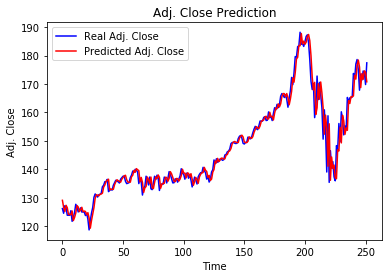

In [220]:
# Repeat predictions with optimized X: X_modeled
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_modeled, y, test_size = 0.2, shuffle = False)

# Data Normalization
scaler_X = MinMaxScaler(feature_range = (0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range = (0, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))

# Fit Multiple Linear Regression Model to training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)

# Compare real adj. close with predicted value
# Inverse normalization of y_pred to obtain interpretable values
predicted_price = scaler_y.inverse_transform(y_pred)

# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

### <a class="anchor" id="RFR">Part 5: Model: Random Forest Regression</a>
As for the multiple linear regression we will test random forest regression model with two different approaches for the features:
1. Adj. Close only: take the last 5 timesteps (days) of adj. close as inputs.
2. Other price information: take the full candle information (Open, High, Low, Close, Adj. Close, Volume) of the previous timestep as inputs.